# Descarga datos

In [ ]:
import requests
from pandas.io.json import json_normalize
import pandas as pd

url="https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=1000000000"
Datos=pd.read_json(url,convert_dates=['fecha_de_notificaci_n','fecha_de_muerte','fis','fecha_diagnostico','fecha_recuperado','fecha_reporte_web'])

In [ ]:
Datos.rename(columns={'id_de_caso':'id_caso','fecha_de_notificaci_n':'fecha_notificacion','c_digo_divipola':'codigo_municipio','ciudad_de_ubicaci_n':'ciudad',
                      'atenci_n':'atencion','tipo':'tipo_contagio','estado':'estado','pa_s_de_procedencia':'pais_procedencia','fis':'fecha_sintomas',
                      'tipo_recuperaci_n':'tipo_recuperacion','fecha_de_muerte':'fecha_muerte'},inplace=True)

In [ ]:
Datos

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,1,2020-03-02,11001,Bogotá D.C.,Bogotá D.C.,Recuperado,19,F,Importado,Leve,ITALIA,2020-02-27T00:00:00.000,2020-03-06,2020-03-13,2020-03-06,PCR,11,380.0,Otro,NaN,NaT
1,2,2020-03-06,76111,Guadalajara de Buga,Valle del Cauca,Recuperado,34,M,Importado,Leve,ESPAÑA,2020-03-04T00:00:00.000,2020-03-09,2020-03-19,2020-03-09,PCR,76,724.0,Otro,NaN,NaT
2,3,2020-03-07,5001,Medellín,Antioquia,Recuperado,50,F,Importado,Leve,ESPAÑA,2020-02-29T00:00:00.000,2020-03-09,2020-03-15,2020-03-09,PCR,5,724.0,Otro,NaN,NaT
3,4,2020-03-09,5001,Medellín,Antioquia,Recuperado,55,M,Relacionado,Leve,NaN,2020-03-06T00:00:00.000,2020-03-11,2020-03-26,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
4,5,2020-03-09,5001,Medellín,Antioquia,Recuperado,25,M,Relacionado,Leve,NaN,2020-03-08T00:00:00.000,2020-03-11,2020-03-23,2020-03-11,PCR,5,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
658451,658492,2020-08-22,5001,Medellín,Antioquia,Casa,18,M,En estudio,Leve,NaN,2020-08-18T00:00:00.000,2020-09-02,NaT,2020-09-05,NaN,5,NaN,NaN,NaN,NaT
658452,658493,2020-08-22,66001,Pereira,Risaralda,Casa,48,F,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-02,NaT,2020-09-05,NaN,66,NaN,NaN,NaN,NaT
658453,658494,2020-08-23,5001,Medellín,Antioquia,Casa,31,F,En estudio,Leve,NaN,2020-08-19T00:00:00.000,2020-09-03,NaT,2020-09-05,NaN,5,NaN,NaN,NaN,NaT
658454,658495,2020-08-24,25754,Soacha,Cundinamarca,Casa,18,F,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,25,NaN,NaN,NaN,NaT


# Análisis datos y dataset final para modelar

In [ ]:
# Cuenta vacíos
Datos.isna().sum()

id_caso                     0
fecha_notificacion          0
codigo_municipio            0
ciudad                      0
departamento                0
atencion                    0
edad                        0
sexo                        0
tipo_contagio               0
estado                      0
pais_procedencia       657491
fecha_sintomas              0
fecha_diagnostico        3980
fecha_recuperado       150681
fecha_reporte_web           0
tipo_recuperacion      150686
codigo_departamento         0
codigo_pais            657495
pertenencia_etnica     375001
nombre_grupo_etnico    647131
fecha_muerte           635949
dtype: int64

In [ ]:
# 5 principales ciudades: Bogotá, Medellín, Cali, Barranquilla y Cartagena de Indias, coincide con las de más casos
Datos['ciudad'].value_counts().head(10)

Bogotá D.C.            223522
Medellín                50942
Cali                    38887
Barranquilla            36611
Cartagena de Indias     20815
Soledad                 13936
Montería                12705
Valledupar               9481
Bucaramanga              9255
Soacha                   9012
Name: ciudad, dtype: int64

In [ ]:
# filtrando ciudades
Datos1=Datos[Datos['ciudad'].isin(['Barranquilla'])]
Datos1.reset_index(inplace=True,drop=True)
Datos1

,id_caso,fecha_notificacion,codigo_municipio,ciudad,departamento,atencion,edad,sexo,tipo_contagio,estado,pais_procedencia,fecha_sintomas,fecha_diagnostico,fecha_recuperado,fecha_reporte_web,tipo_recuperacion,codigo_departamento,codigo_pais,pertenencia_etnica,nombre_grupo_etnico,fecha_muerte
0,59,2020-03-14,8001,Barranquilla,Barranquilla D.E.,Recuperado,20,M,Importado,Leve,ESPAÑA,2020-03-13T00:00:00.000,2020-03-16,2020-03-27,2020-03-16,PCR,8,724.0,Otro,NaN,NaT
1,61,2020-03-16,8001,Barranquilla,Barranquilla D.E.,Recuperado,21,M,Importado,Leve,ESPAÑA,2020-03-10T00:00:00.000,2020-03-16,2020-03-24,2020-03-16,PCR,8,724.0,Otro,NaN,NaT
2,104,2020-03-19,8001,Barranquilla,Barranquilla D.E.,Recuperado,48,F,Importado,Leve,ESPAÑA,2020-03-15T00:00:00.000,2020-03-19,2020-03-25,2020-03-19,PCR,8,724.0,Otro,NaN,NaT
3,126,2020-03-18,8001,Barranquilla,Barranquilla D.E.,Recuperado,52,F,Importado,Leve,ESTADOS UNIDOS,2020-03-06T00:00:00.000,2020-03-19,2020-03-31,2020-03-19,PCR,8,840.0,Otro,NaN,NaT
4,127,2020-03-18,8001,Barranquilla,Barranquilla D.E.,Recuperado,30,F,Relacionado,Leve,NaN,2020-03-16T00:00:00.000,2020-03-19,2020-03-29,2020-03-19,PCR,8,NaN,Otro,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36606,658298,2020-08-24,8001,Barranquilla,Barranquilla D.E.,Casa,20,F,En estudio,Leve,NaN,2020-08-22T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,8,NaN,NaN,NaN,NaT
36607,658301,2020-08-24,8001,Barranquilla,Barranquilla D.E.,Casa,20,M,En estudio,Leve,NaN,2020-08-22T00:00:00.000,2020-09-04,NaT,2020-09-05,NaN,8,NaN,NaN,NaN,NaT
36608,658445,2020-08-22,8001,Barranquilla,Barranquilla D.E.,Casa,17,M,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-02,NaT,2020-09-05,NaN,8,NaN,NaN,NaN,NaT
36609,658446,2020-08-22,8001,Barranquilla,Barranquilla D.E.,Casa,18,M,En estudio,Leve,NaN,2020-08-20T00:00:00.000,2020-09-02,NaT,2020-09-05,NaN,8,NaN,NaN,NaN,NaT


# **Metodologías propuestas y desarrollo de los modelos**

## Metodología 1: Nuevos ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

In [ ]:
tabla_nuevos

,fecha_reporte_web,casos_nuevos_reportados,casos_confirmados
0,2020-03-16,2,2
1,2020-03-19,3,5
2,2020-03-21,2,7
3,2020-03-24,2,9
4,2020-03-25,3,12
...,...,...,...
156,2020-08-28,71,35919
157,2020-08-29,64,35983
158,2020-08-30,85,36068
159,2020-08-31,62,36130


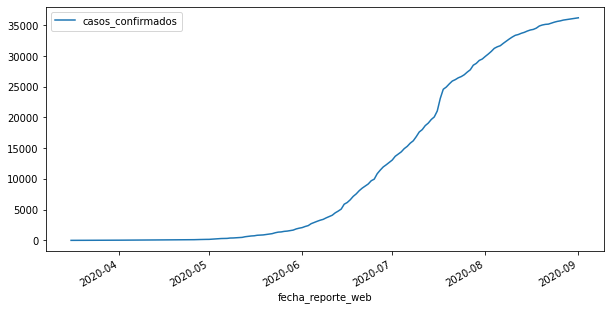

In [ ]:
# los casos confirmados no pueden ser con modelo basado en la tendencia, se tiene que predecir con el resultado de la suma de los casos nuevos reportados
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_confirmados',figsize=(10, 5)).figure.savefig('1.png')

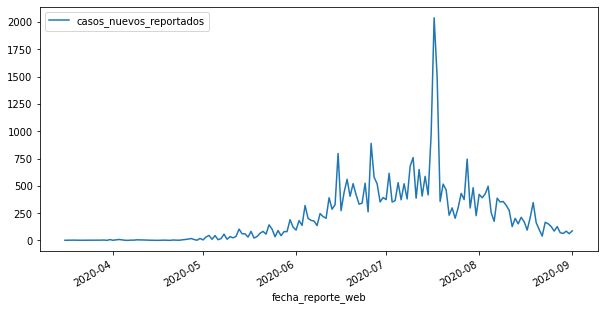

In [ ]:
tabla_nuevos.plot(x='fecha_reporte_web',y='casos_nuevos_reportados',figsize=(10, 5)).figure.savefig('2.png')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


mean1=55.962500, mean2=391.864198
variance1=6292.061094, variance2=87717.030940


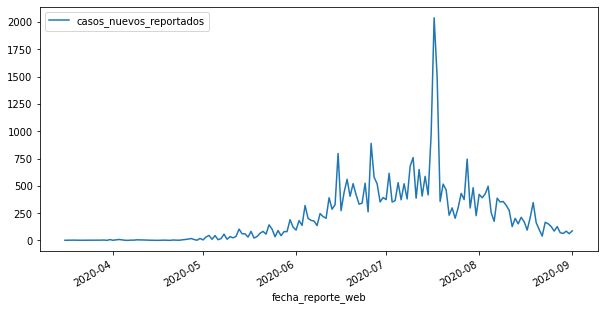

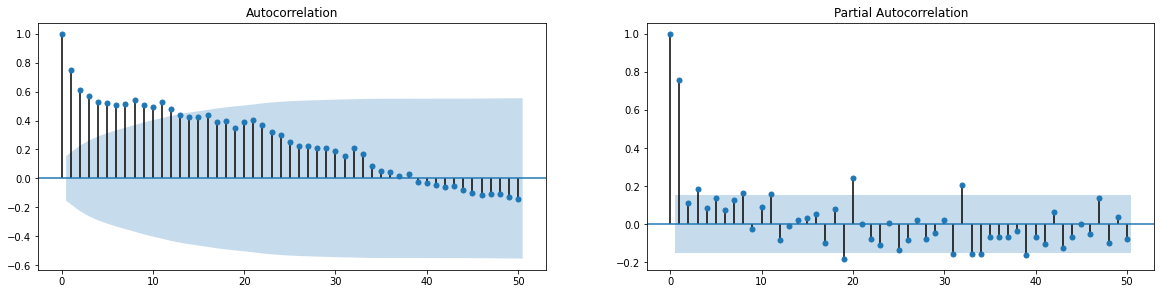

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M1Nuevos=M1Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M1Nuevos.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Nuevos.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Nuevos, lags=50, ax=ax2)

X=M1Nuevos.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))


mean1=2.768892, mean2=5.733442
variance1=3.189000, variance2=0.518192


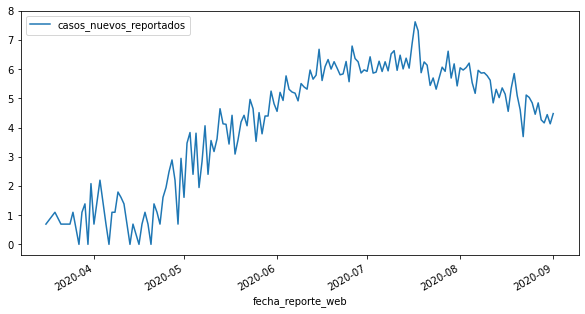

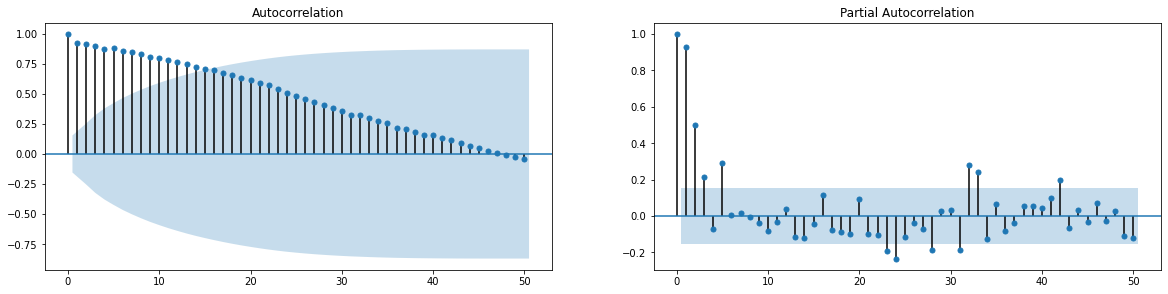

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1NuevosLog=np.log(M1Nuevos)
plt.rcParams["figure.figsize"] = (10,5)
M1NuevosLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLog, lags=50, ax=ax2)

X=M1NuevosLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

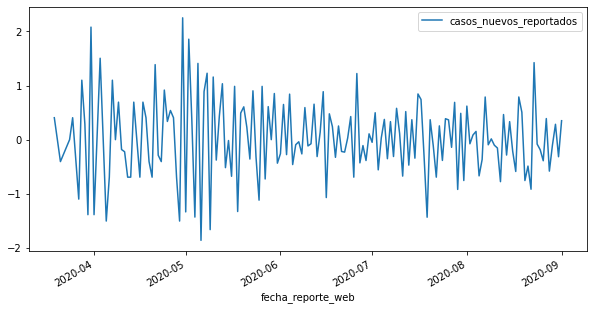

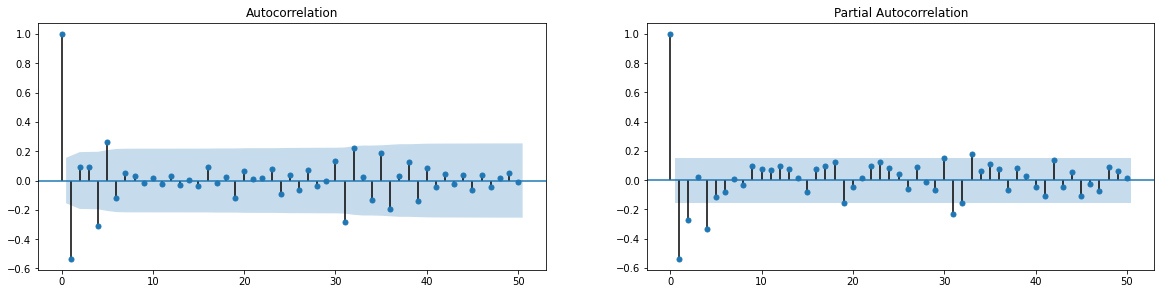

In [ ]:
# Primera diferencia para volver estacional
M1NuevosLogDif=M1NuevosLog.diff()
M1NuevosLogDif=M1NuevosLogDif[1:]
M1NuevosLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1NuevosLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1NuevosLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(161, 1)
(128, 1)
(20, 1)
(13, 1)


In [ ]:
pip install pmdarima

     |████████████████████████████████| 1.5MB 2.9MB/s 
     |████████████████████████████████| 2.1MB 15.2MB/s 
     |████████████████████████████████| 9.5MB 34.9MB/s 
  Found existing installation: Cython 0.29.21
    Uninstalling Cython-0.29.21:
      Successfully uninstalled Cython-0.29.21
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  128
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -119.330
Date:                Wed, 02 Sep 2020   AIC                            244.660
Time:                        18:31:09   BIC                            253.192
Sample:                             0   HQIC                           248.126
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0427      0.016      2.628      0.009       0.011       0.075
ma.L1         -0.7192      0.058    -12.297      0.000      -0.834      -0.605
sigma2         0.3812      0.051      7.469      0.000       0.281       0.481
===================================================================================
Ljung-Box (Q):                       55.65   Jarque-Bera (JB):                 0.32
Prob(Q):                              0.05   Prob(JB):                         0.85
Heteroskedasticity (H):               0.36   Skew:                             0.04
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


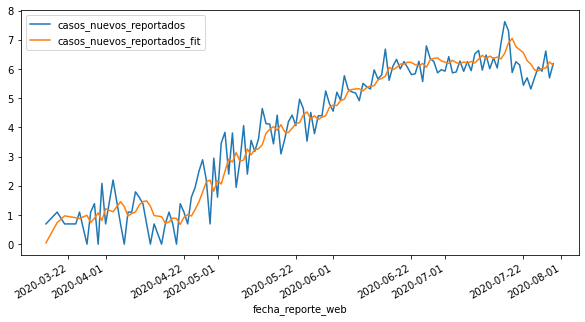

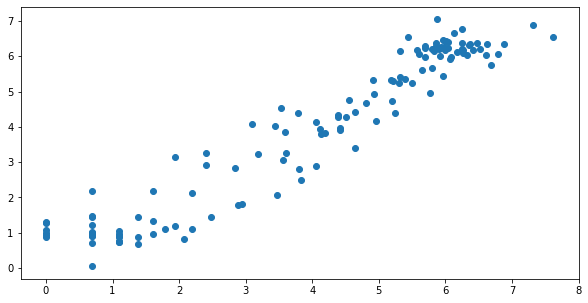

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


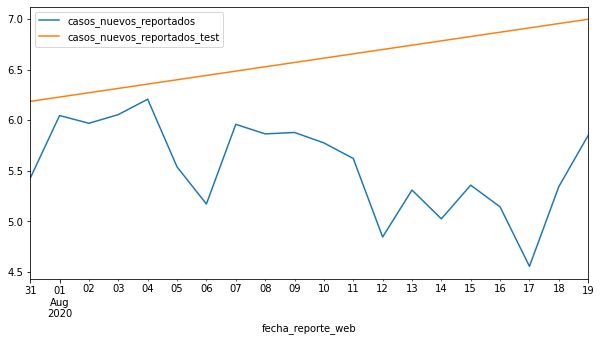

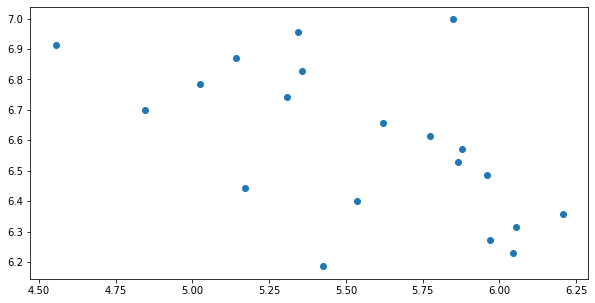

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5)).figure.savefig('3.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.savefig('4.png')
plt.show()


M1NuevosLogTest['casos_nuevos_reportados_test']=arima.predict(n_periods=(len(M1NuevosLogTest))) 
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5)).figure.savefig('5.png')

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.savefig('6.png')
plt.show()

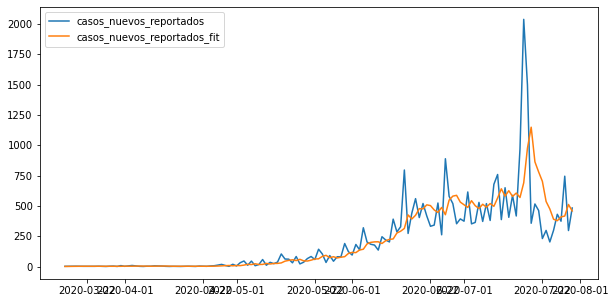

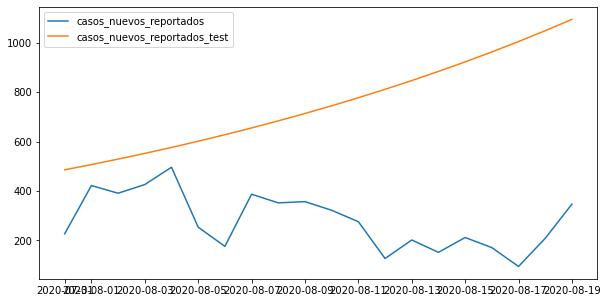

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fit'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fit'])
plt.savefig('7.png')
plt.show()

FM1NuevosTest=np.exp(M1NuevosLogTest)
plt.plot(FM1NuevosTest['casos_nuevos_reportados'])
plt.plot(FM1NuevosTest['casos_nuevos_reportados_test'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_test'])
plt.savefig('8.png')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Nuevos['casos_nuevos_reportados'],FM1Nuevos['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1NuevosTest['casos_nuevos_reportados'],FM1NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)

MSE in train: 37293.124569
MSE in test: 290718.806373


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1NuevosLogTrain=M1NuevosLog[:int(len(M1NuevosLog)*p_train)]
M1NuevosLogTest=M1NuevosLog[int(len(M1NuevosLog)*p_train):int(len(M1NuevosLog)*(p_train+p_test))]
M1NuevosLogForecast=M1NuevosLog[int(len(M1NuevosLog)*(p_train+p_test)):]
print(M1NuevosLog.shape)
print(M1NuevosLogTrain.shape)
print(M1NuevosLogTest.shape)
print(M1NuevosLogForecast.shape)

(159, 1)
(127, 1)
(19, 1)
(13, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


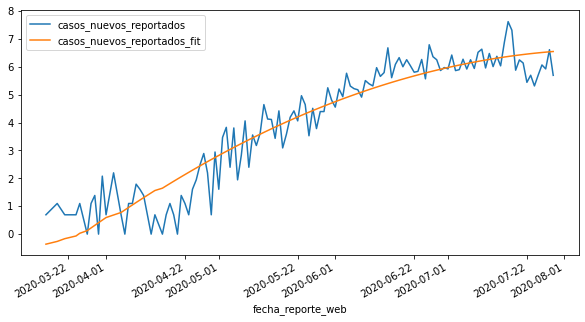

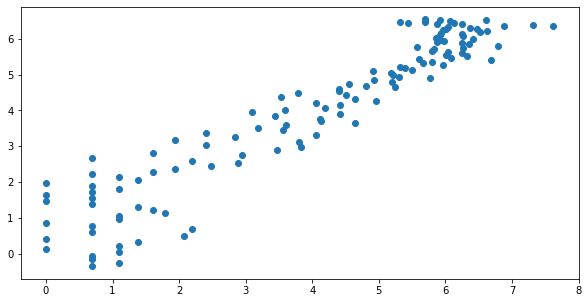

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


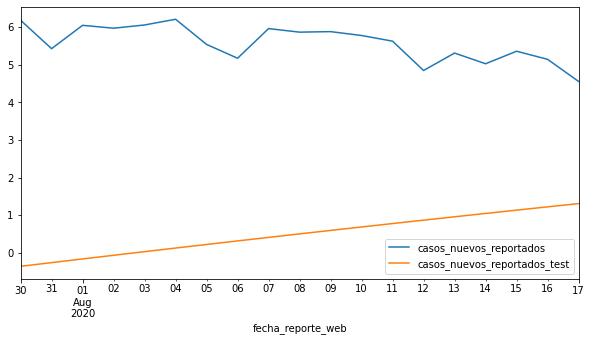

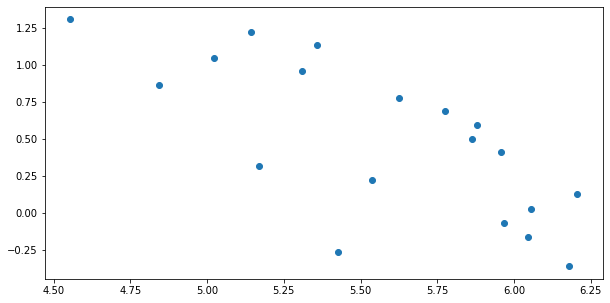

Mean squared error: 0.50
Variance score: 0.89


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1NuevosLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1NuevosLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1NuevosLogTrain['casos_nuevos_reportados'].values.reshape(-1,1))
M1NuevosLogTrain['casos_nuevos_reportados_fit']=model.predict(x_trainpoly)

plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])
plt.show()

M1NuevosLogTest['casos_nuevos_reportados_test']=model.predict(x_testpoly)
plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit'])))

print('Variance score: %.2f' % r2_score(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fit']))

#4,3,2
#Mean squared error: 0.15, 0.19, 0.24
#Variance score: 0.96, 0.95, 0.94

# LinnearRegression() 0.24, 0.94

In [ ]:
M1NuevosLogTrain['Errores']=M1NuevosLogTrain['casos_nuevos_reportados']-M1NuevosLogTrain['casos_nuevos_reportados_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1NuevosLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  127
Model:               SARIMAX(1, 0, 1)   Log Likelihood                -117.604
Date:                Tue, 01 Sep 2020   AIC                            241.209
Time:                        02:58:20   BIC                            249.742
Sample:                             0   HQIC                           244.676
                                - 127                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9189      0.047     19.511      0.000       0.827       1.011
ma.L1         -0.6678      0.089     -7.480      0.000      -0.843      -0.493
sigma2         0.3715      0.048      7.719      0.000       0.277       0.466
===================================================================================
Ljung-Box (Q):                       56.12   Jarque-Bera (JB):                 1.33
Prob(Q):                              0.05   Prob(JB):                         0.51
Heteroskedasticity (H):               0.33   Skew:                            -0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.89
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


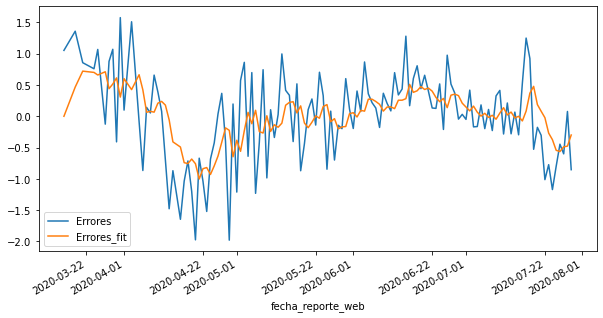

In [ ]:
M1NuevosLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1NuevosLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


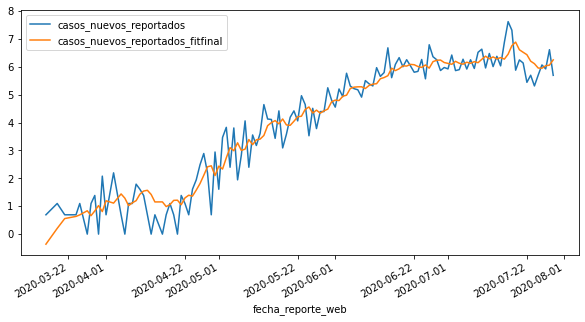

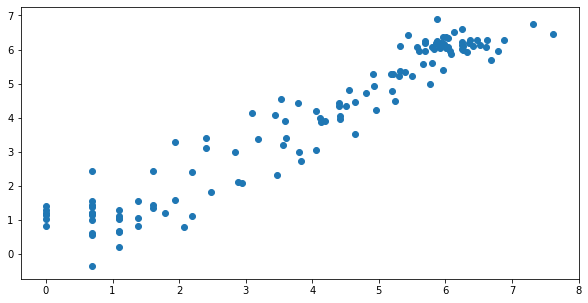

In [ ]:
M1NuevosLogTrain['casos_nuevos_reportados_fitfinal']=M1NuevosLogTrain['casos_nuevos_reportados_fit']+M1NuevosLogTrain['Errores_fit']
plot=M1NuevosLogTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTrain['casos_nuevos_reportados'],M1NuevosLogTrain['casos_nuevos_reportados_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


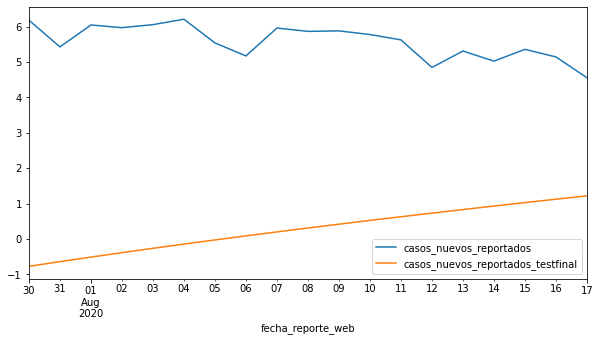

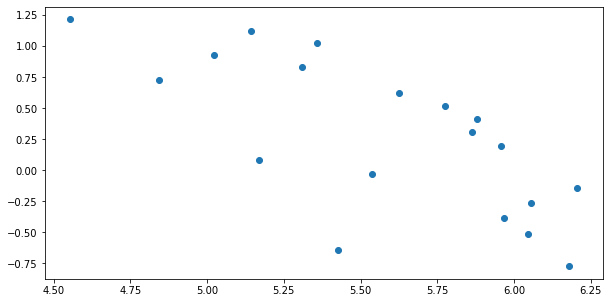

In [ ]:
M1NuevosLogTest['Errores_test']=arima.predict(n_periods=(len(M1NuevosLogTest)))
M1NuevosLogTest['casos_nuevos_reportados_testfinal']=M1NuevosLogTest['casos_nuevos_reportados_test']+M1NuevosLogTest['Errores_test']

plot=M1NuevosLogTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1NuevosLogTest['casos_nuevos_reportados'],M1NuevosLogTest['casos_nuevos_reportados_testfinal'])
plt.show() 

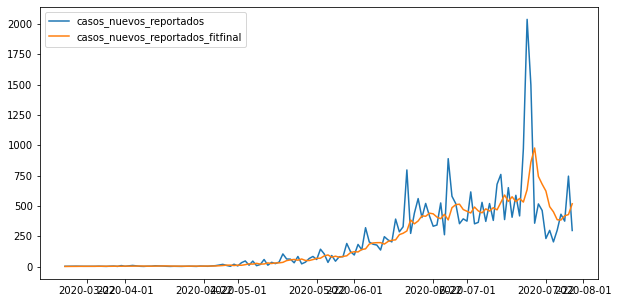

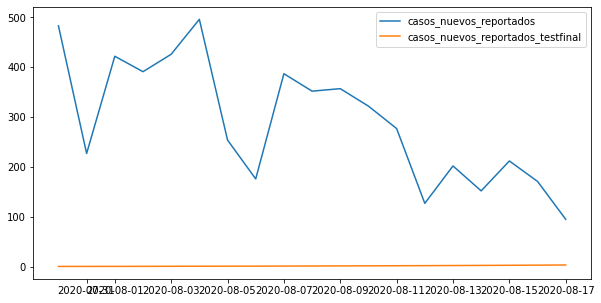

In [ ]:
FM1Nuevos=np.exp(M1NuevosLogTrain)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_fitfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_fitfinal'])
plt.show()

FM1Nuevos=np.exp(M1NuevosLogTest)
plt.plot(FM1Nuevos['casos_nuevos_reportados'])
plt.plot(FM1Nuevos['casos_nuevos_reportados_testfinal'])
plt.legend(['casos_nuevos_reportados','casos_nuevos_reportados_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Muerte ARIMA Y POLINOMIAL CON ERORRES ARIMA



In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

In [ ]:
tabla_muerte

,fecha_muerte,casos_muerte
0,2020-04-02,1
1,2020-04-03,1
2,2020-04-09,1
3,2020-04-20,1
4,2020-04-22,1
...,...,...
121,2020-08-26,1
122,2020-08-27,3
123,2020-08-28,5
124,2020-08-29,3


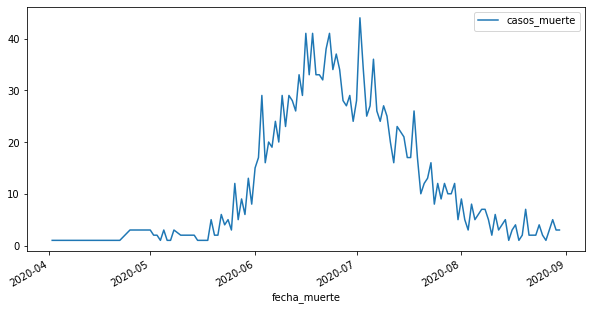

In [ ]:
tabla_muerte.plot(x='fecha_muerte',y='casos_muerte',figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


mean1=14.301587, mean2=12.730159
variance1=190.877299, variance2=108.038297


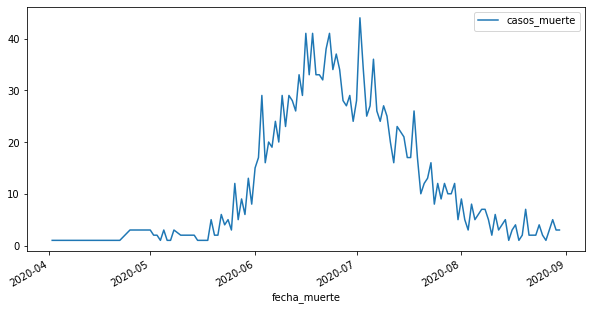

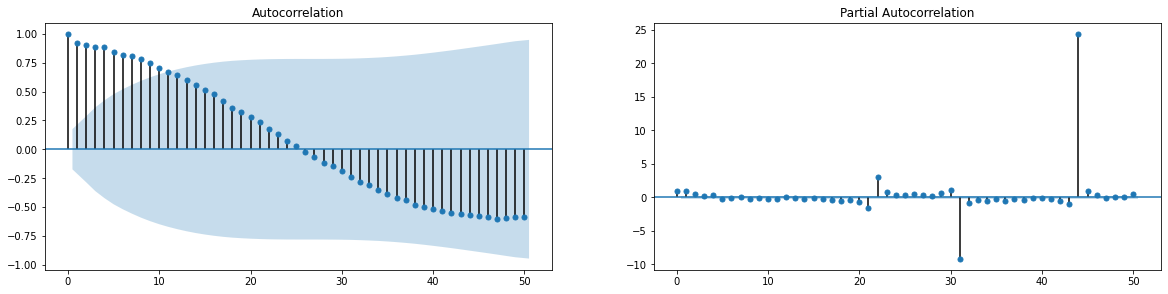

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M1Muerte.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Muerte.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Muerte, lags=50, ax=ax2)

X=M1Muerte.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  Default is None.


mean1=1.922384, mean2=2.132739
variance1=1.864850, variance2=0.976564


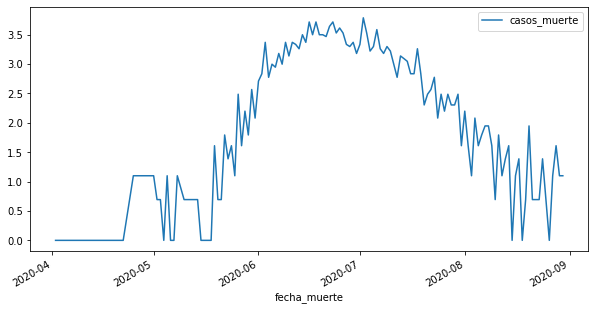

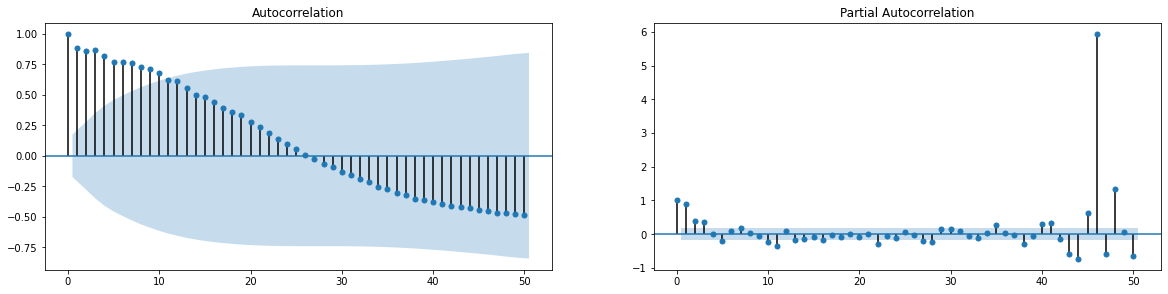

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1MuerteLog=np.log(M1Muerte)
plt.rcParams["figure.figsize"] = (10,5)
M1MuerteLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLog, lags=50, ax=ax2)

X=M1MuerteLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

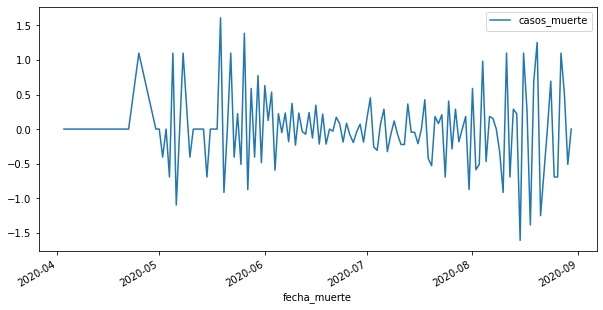

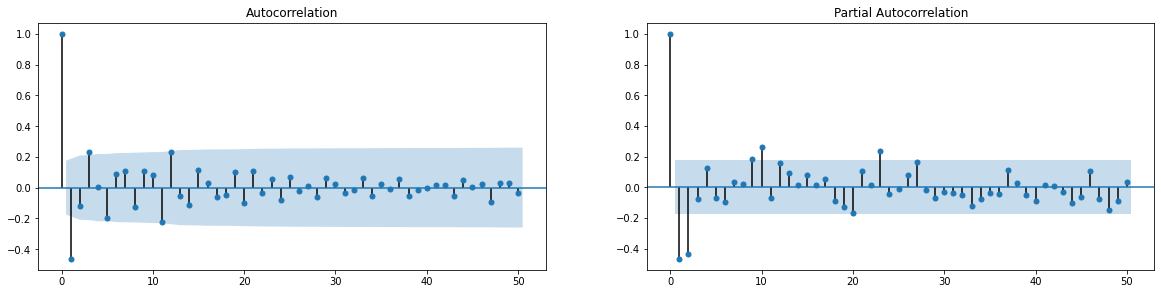

In [ ]:
# Primera diferencia para volver estacional
M1MuerteLogDif=M1MuerteLog.diff()
M1MuerteLogDif=M1MuerteLogDif[1:]
M1MuerteLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1MuerteLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1MuerteLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(126, 1)
(100, 1)
(15, 1)
(11, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain)
arima.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(0, 2, 2)   Log Likelihood                 -50.223
Date:                Wed, 02 Sep 2020   AIC                            106.446
Time:                        18:33:05   BIC                            114.201
Sample:                             0   HQIC                           109.583
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.5560      0.081    -19.287      0.000      -1.714      -1.398
ma.L2          0.5975      0.081      7.336      0.000       0.438       0.757
sigma2         0.1569      0.017      9.346      0.000       0.124       0.190
===================================================================================
Ljung-Box (Q):                       31.45   Jarque-Bera (JB):                51.41
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                             0.97
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


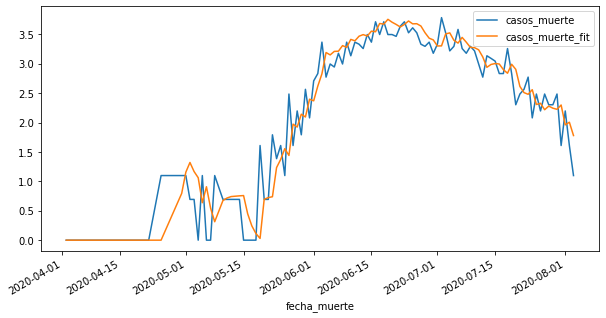

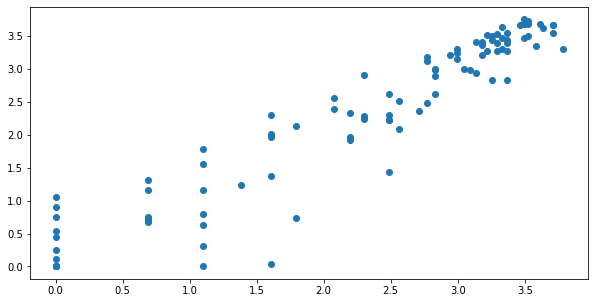

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


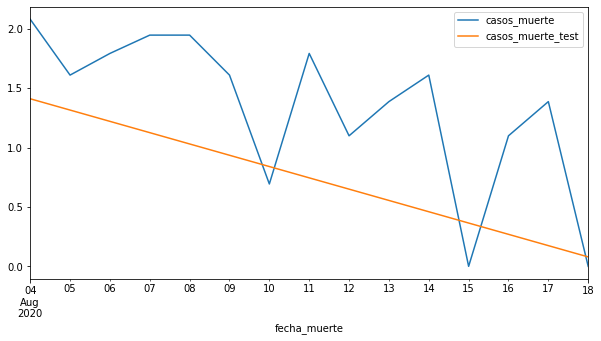

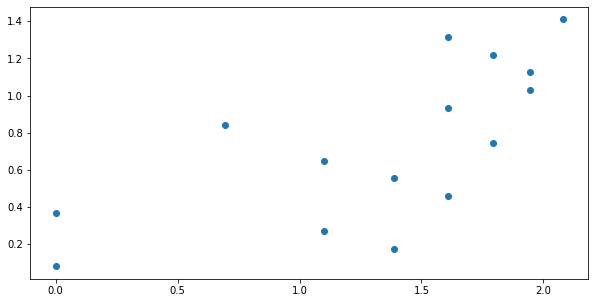

In [ ]:
M1MuerteLogTrain['casos_muerte_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()



M1MuerteLogTest['casos_muerte_test']=arima.predict(n_periods=(len(M1MuerteLogTest))) 
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

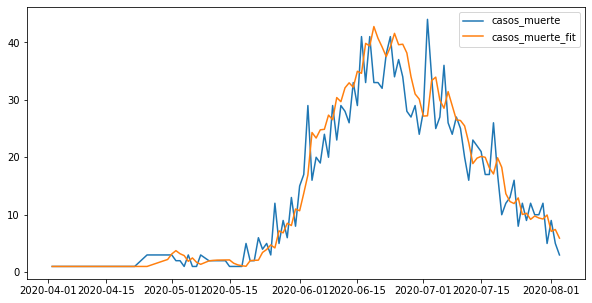

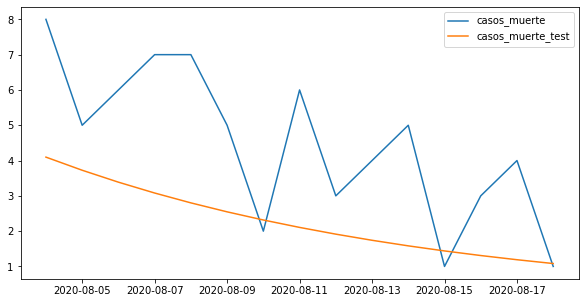

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fit'])
plt.legend(['casos_muerte','casos_muerte_fit'])
plt.show()

FM1MuerteTest=np.exp(M1MuerteLogTest)
plt.plot(FM1MuerteTest['casos_muerte'])
plt.plot(FM1MuerteTest['casos_muerte_test'])
plt.legend(['casos_muerte','casos_muerte_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Muerte['casos_muerte'],FM1Muerte['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1MuerteTest['casos_muerte'],FM1MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 21.133237
MSE in test: 7.124369


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1MuerteLogTrain=M1MuerteLog[:int(len(M1MuerteLog)*p_train)]
M1MuerteLogTest=M1MuerteLog[int(len(M1MuerteLog)*p_train):int(len(M1MuerteLog)*(p_train+p_test))]
M1MuerteLogForecast=M1MuerteLog[int(len(M1MuerteLog)*(p_train+p_test)):]
print(M1MuerteLog.shape)
print(M1MuerteLogTrain.shape)
print(M1MuerteLogTest.shape)
print(M1MuerteLogForecast.shape)

(124, 1)
(99, 1)
(15, 1)
(10, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


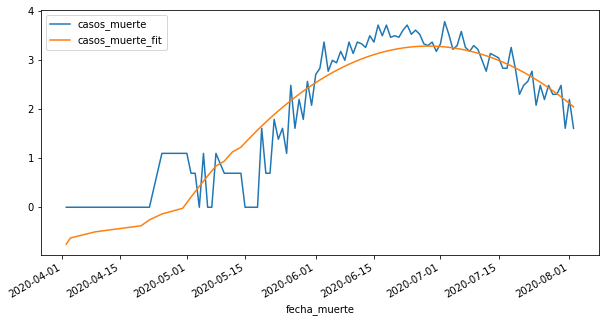

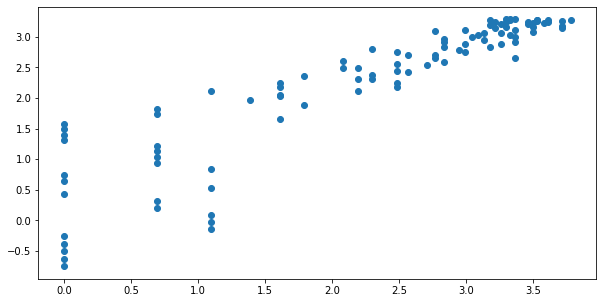

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


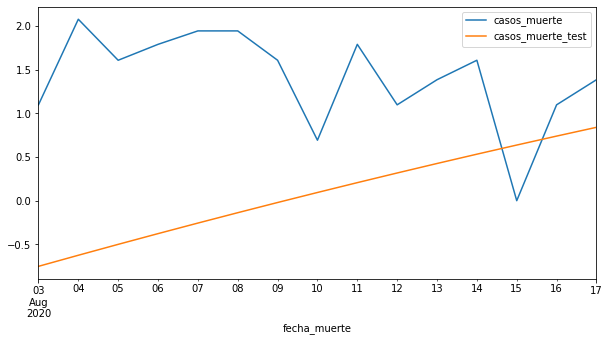

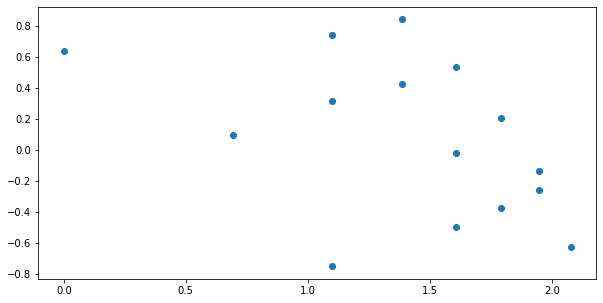

Mean squared error: 0.27
Variance score: 0.82


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1MuerteLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1MuerteLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=2)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1MuerteLogTrain['casos_muerte'].values.reshape(-1,1))
M1MuerteLogTrain['casos_muerte_fit']=model.predict(x_trainpoly)

plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])
plt.show()

M1MuerteLogTest['casos_muerte_test']=model.predict(x_testpoly)
plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit'])))

print('Variance score: %.2f' % r2_score(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fit']))

#3
#Mean squared error: 0.11
#Variance score: 0.94

# LinnearRegression()

In [ ]:
M1MuerteLogTrain['Errores']=M1MuerteLogTrain['casos_muerte']-M1MuerteLogTrain['casos_muerte_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1MuerteLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  return -self.score(params, *args) / nobs


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   99
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -42.567
Date:                Tue, 01 Sep 2020   AIC                             93.133
Time:                        03:01:03   BIC                            103.514
Sample:                             0   HQIC                            97.333
                                 - 99                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8923      0.047     19.066      0.000       0.801       0.984
ma.L1         -0.6140      0.102     -6.002      0.000      -0.815      -0.414
ma.L2          0.1758      0.090      1.948      0.051      -0.001       0.353
sigma2         0.1371      0.017      7.889      0.000       0.103       0.171
===================================================================================
Ljung-Box (Q):                       27.80   Jarque-Bera (JB):                 4.10
Prob(Q):                              0.93   Prob(JB):                         0.13
Heteroskedasticity (H):               0.24   Skew:                             0.19
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


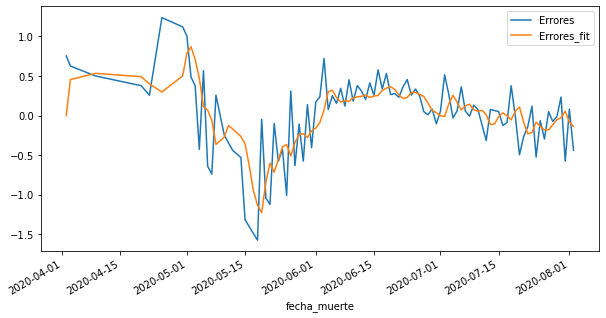

In [ ]:
M1MuerteLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1MuerteLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


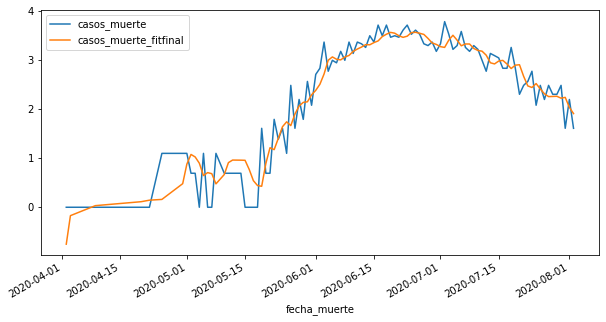

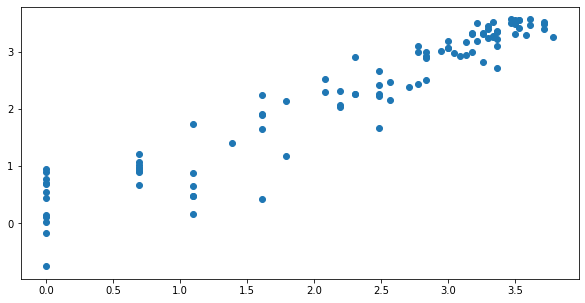

In [ ]:
M1MuerteLogTrain['casos_muerte_fitfinal']=M1MuerteLogTrain['casos_muerte_fit']+M1MuerteLogTrain['Errores_fit']
plot=M1MuerteLogTrain[['casos_muerte', 'casos_muerte_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTrain['casos_muerte'],M1MuerteLogTrain['casos_muerte_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


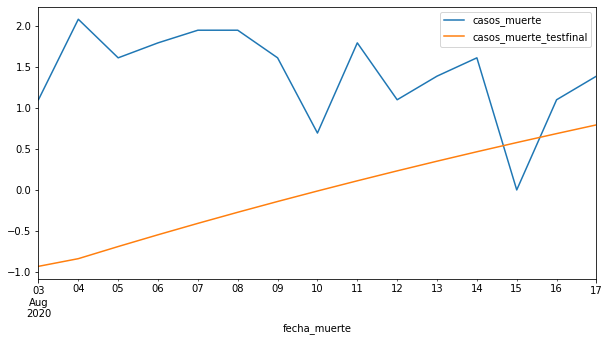

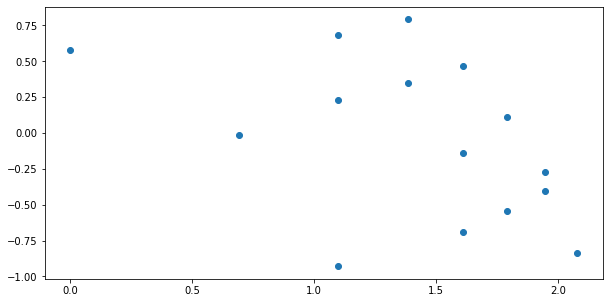

In [ ]:
M1MuerteLogTest['Errores_test']=arima.predict(n_periods=(len(M1MuerteLogTest)))
M1MuerteLogTest['casos_muerte_testfinal']=M1MuerteLogTest['casos_muerte_test']+M1MuerteLogTest['Errores_test']

plot=M1MuerteLogTest[['casos_muerte', 'casos_muerte_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1MuerteLogTest['casos_muerte'],M1MuerteLogTest['casos_muerte_testfinal'])
plt.show() 

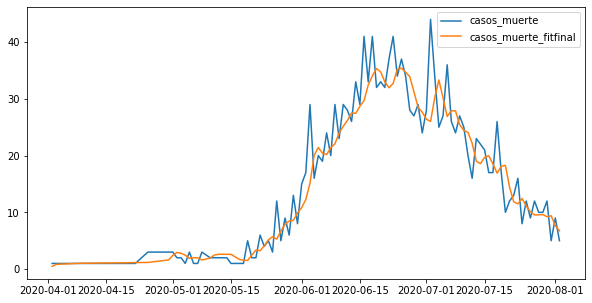

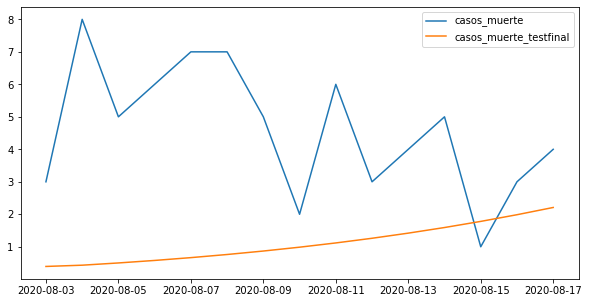

In [ ]:
FM1Muerte=np.exp(M1MuerteLogTrain)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_fitfinal'])
plt.legend(['casos_muerte','casos_muerte_fitfinal'])
plt.show()

FM1Muerte=np.exp(M1MuerteLogTest)
plt.plot(FM1Muerte['casos_muerte'])
plt.plot(FM1Muerte['casos_muerte_testfinal'])
plt.legend(['casos_muerte','casos_muerte_testfinal'])
plt.show()

#x_fore=M1MuerteLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 1: Recuperado ARIMA Y POLINOMIAL CON ERORRES ARIMA

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

In [ ]:
tabla_recuperado

,fecha_recuperado,casos_recuperado
0,2020-03-24,2
1,2020-03-25,1
2,2020-03-27,1
3,2020-03-28,1
4,2020-03-29,1
...,...,...
140,2020-08-28,380
141,2020-08-29,164
142,2020-08-30,273
143,2020-08-31,101


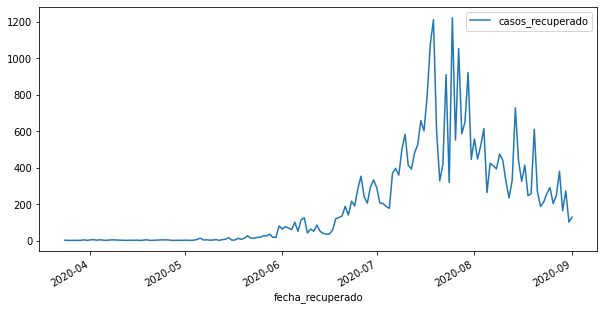

In [ ]:
tabla_recuperado.plot(x='fecha_recuperado',y='casos_recuperado',figsize=(10, 5))

mean1=26.958333, mean2=425.164384
variance1=1297.984375, variance2=61148.219553


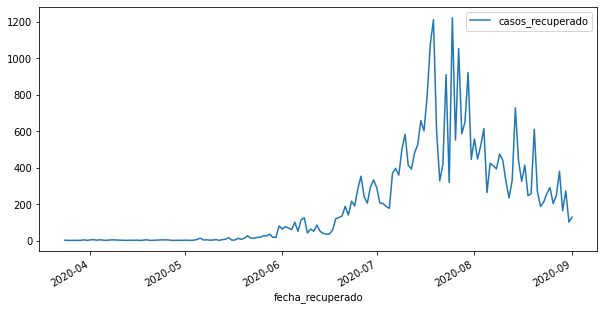

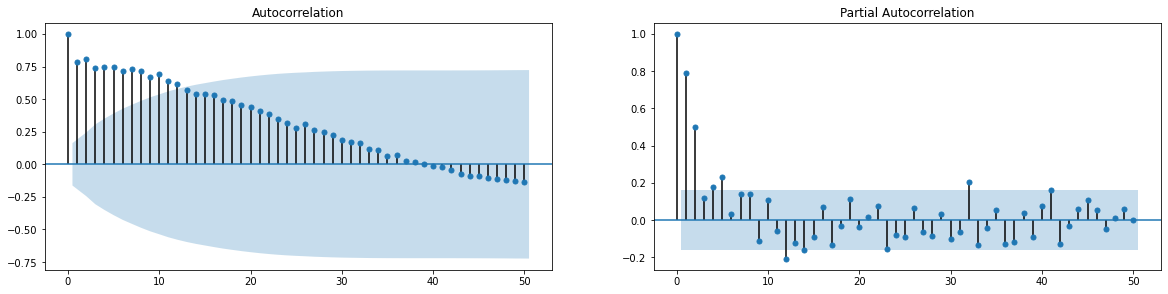

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose

# Serie normal
M1Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M1Recuperado.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1Recuperado.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1Recuperado, lags=50, ax=ax2)

X=M1Recuperado.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=2.192784, mean2=5.904537
variance1=2.631304, variance2=0.290966


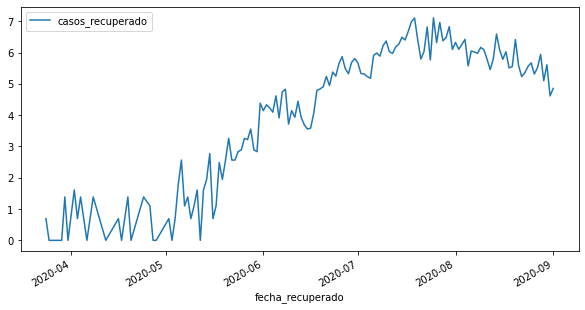

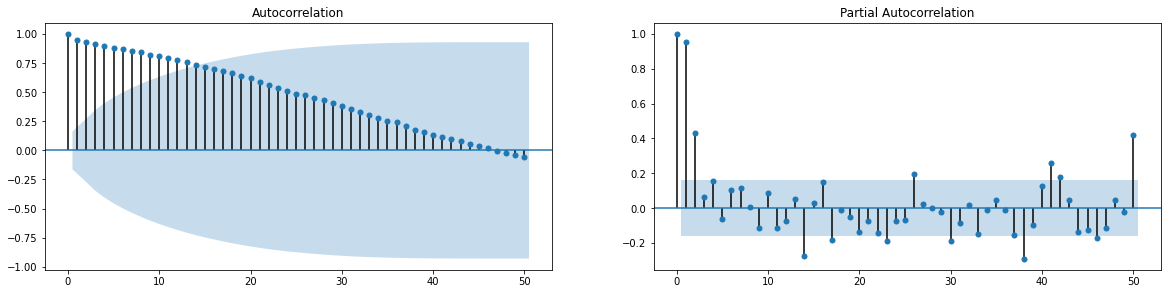

In [ ]:
# Como varianza no constante, transformación log para estabilizar varianza
M1RecuperadoLog=np.log(M1Recuperado)
plt.rcParams["figure.figsize"] = (10,5)
M1RecuperadoLog.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLog.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLog, lags=50, ax=ax2)

X=M1RecuperadoLog.values
split=round(len(X)/2)
X1=X[0:split]
X2=X[split:]
mean1,mean2=X1.mean(),X2.mean()
var1,var2=X1.var(),X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

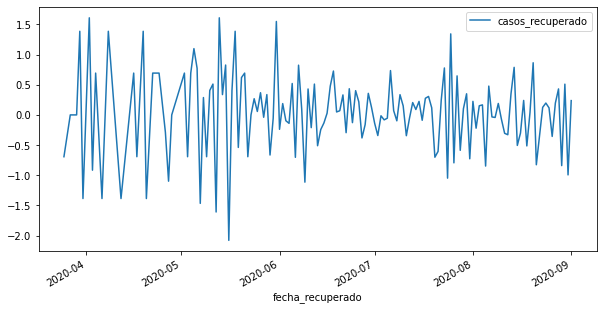

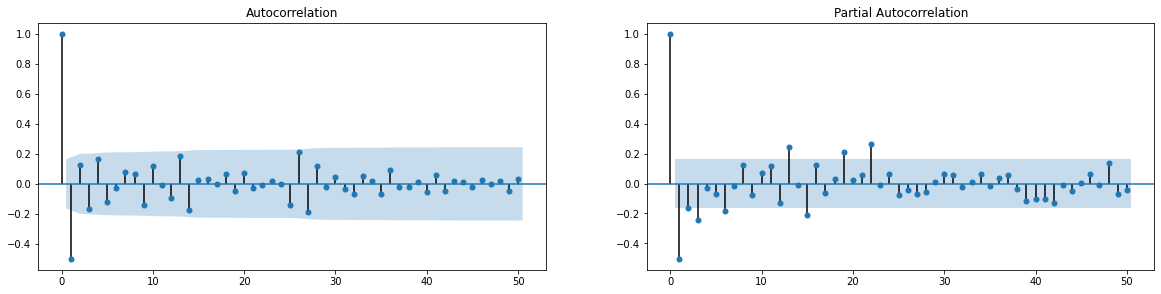

In [ ]:
# Primera diferencia para volver estacional
M1RecuperadoLogDif=M1RecuperadoLog.diff()
M1RecuperadoLogDif=M1RecuperadoLogDif[1:]
M1RecuperadoLogDif.plot()

fig=plt.figure(figsize=(20,10))
ax1=fig.add_subplot(221)
fig=sm.graphics.tsa.plot_acf(M1RecuperadoLogDif.squeeze(), lags=50, ax=ax1)
ax2=fig.add_subplot(222)
fig=sm.graphics.tsa.plot_pacf(M1RecuperadoLogDif, lags=50, ax=ax2)

**MODELO ARIMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(145, 1)
(116, 1)
(17, 1)
(12, 1)


In [ ]:
# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain)
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  116
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -100.502
Date:                Wed, 02 Sep 2020   AIC                            207.004
Time:                        18:34:46   BIC                            215.239
Sample:                             0   HQIC                           210.347
                                - 116                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0539      0.016      3.291      0.001       0.022       0.086
ma.L1         -0.7041      0.075     -9.329      0.000      -0.852      -0.556
sigma2         0.3342      0.047      7.167      0.000       0.243       0.426
===================================================================================
Ljung-Box (Q):                       36.85   Jarque-Bera (JB):                 0.22
Prob(Q):                              0.61   Prob(JB):                         0.89
Heteroskedasticity (H):               0.26   Skew:                             0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                         2.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


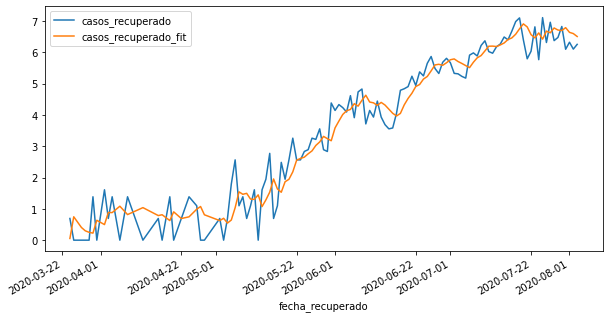

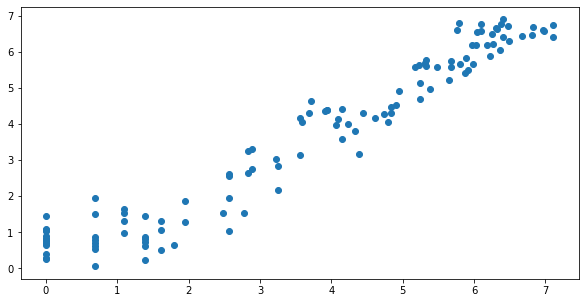

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


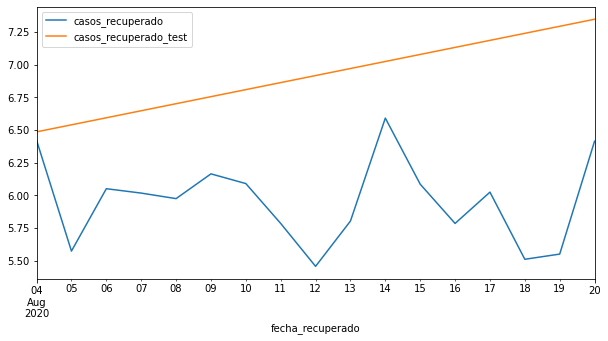

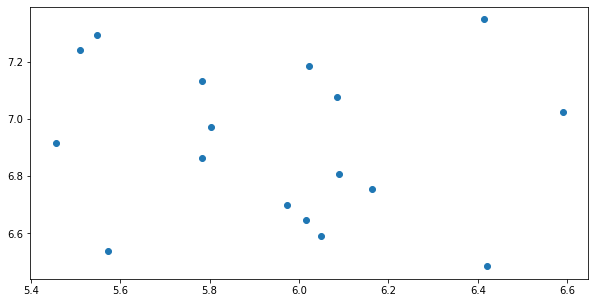

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()



M1RecuperadoLogTest['casos_recuperado_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest))) 
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

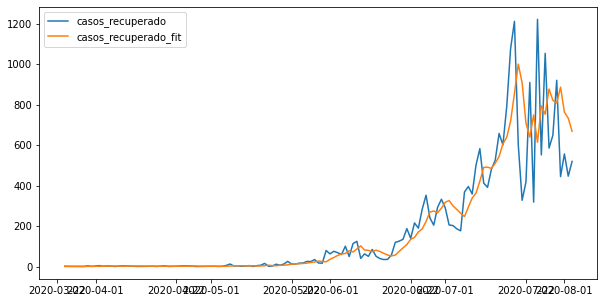

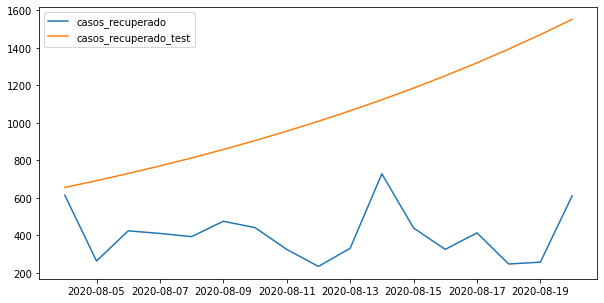

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fit'])
plt.legend(['casos_recuperado','casos_recuperado_fit'])
plt.show()

FM1RecuperadoTest=np.exp(M1RecuperadoLogTest)
plt.plot(FM1RecuperadoTest['casos_recuperado'])
plt.plot(FM1RecuperadoTest['casos_recuperado_test'])
plt.legend(['casos_recuperado','casos_recuperado_test'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(FM1Recuperado['casos_recuperado'],FM1Recuperado['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(FM1RecuperadoTest['casos_recuperado'],FM1RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 20031.596576
MSE in test: 502806.417402


**MODELO POLINOMIAL Y ERORRES ARMA**

In [ ]:
p_train=0.80
p_test=0.12
p_forecast=0.08
M1RecuperadoLogTrain=M1RecuperadoLog[:int(len(M1RecuperadoLog)*p_train)]
M1RecuperadoLogTest=M1RecuperadoLog[int(len(M1RecuperadoLog)*p_train):int(len(M1RecuperadoLog)*(p_train+p_test))]
M1RecuperadoLogForecast=M1RecuperadoLog[int(len(M1RecuperadoLog)*(p_train+p_test)):]
print(M1RecuperadoLog.shape)
print(M1RecuperadoLogTrain.shape)
print(M1RecuperadoLogTest.shape)
print(M1RecuperadoLogForecast.shape)

(143, 1)
(114, 1)
(17, 1)
(12, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


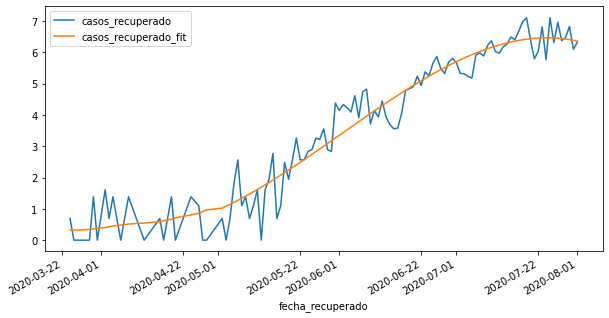

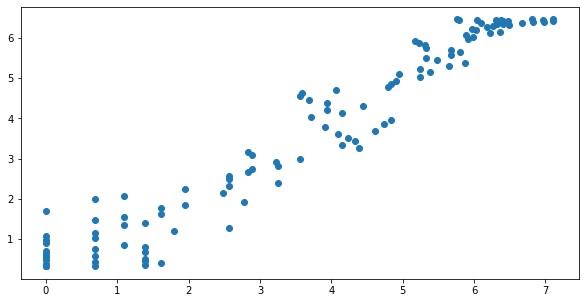

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


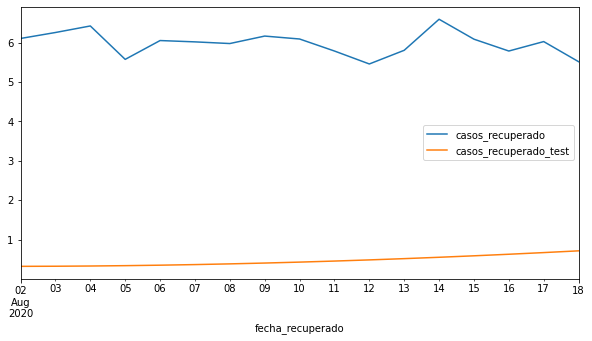

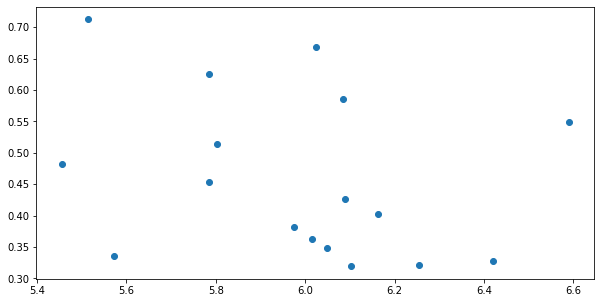

Mean squared error: 0.32
Variance score: 0.94


In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

x_train=M1RecuperadoLogTrain.index.factorize()[0].reshape(-1,1)
x_test=M1RecuperadoLogTest.index.factorize()[0].reshape(-1,1)

poly=PolynomialFeatures(degree=3)
poly=poly.fit(x_train)

x_trainpoly=poly.transform(x_train)
x_testpoly=poly.transform(x_test)

model=LinearRegression()
model.fit(x_trainpoly, M1RecuperadoLogTrain['casos_recuperado'].values.reshape(-1,1))
M1RecuperadoLogTrain['casos_recuperado_fit']=model.predict(x_trainpoly)

plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])
plt.show()

M1RecuperadoLogTest['casos_recuperado_test']=model.predict(x_testpoly)
plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10,5))

plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_test'])
plt.show()

print("Mean squared error: %.2f"
      % (mean_squared_error(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit'])))

print('Variance score: %.2f' % r2_score(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fit']))

#
#Mean squared error: 0.24
#Variance score: 0.94

# LinnearRegression() 

In [ ]:
M1RecuperadoLogTrain['Errores']=M1RecuperadoLogTrain['casos_recuperado']-M1RecuperadoLogTrain['casos_recuperado_fit']

# Modelo identificado por la identificación automática
from pmdarima import auto_arima
arima=auto_arima(M1RecuperadoLogTrain['Errores'])
arima.summary()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:949: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  self.enforce_stationarity and


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  114
Model:               SARIMAX(0, 0, 2)   Log Likelihood                 -91.864
Date:                Tue, 01 Sep 2020   AIC                            189.728
Time:                        03:04:32   BIC                            197.937
Sample:                             0   HQIC                           193.060
                                - 114                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1800      0.084      2.140      0.032       0.015       0.345
ma.L2          0.1830      0.085      2.161      0.031       0.017       0.349
sigma2         0.2932      0.037      7.849      0.000       0.220       0.366
===================================================================================
Ljung-Box (Q):                       36.18   Jarque-Bera (JB):                 0.68
Prob(Q):                              0.64   Prob(JB):                         0.71
Heteroskedasticity (H):               0.24   Skew:                            -0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


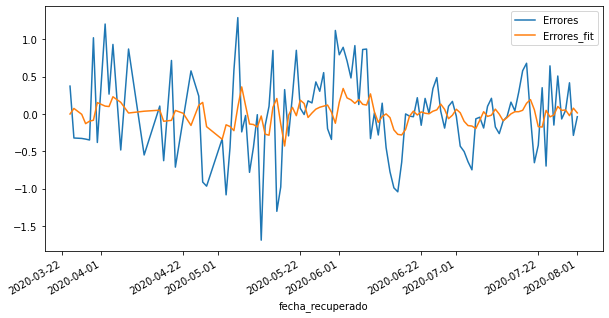

In [ ]:
M1RecuperadoLogTrain['Errores_fit']=arima.predict_in_sample()
plot=M1RecuperadoLogTrain[['Errores', 'Errores_fit']].plot(figsize=(10, 5))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


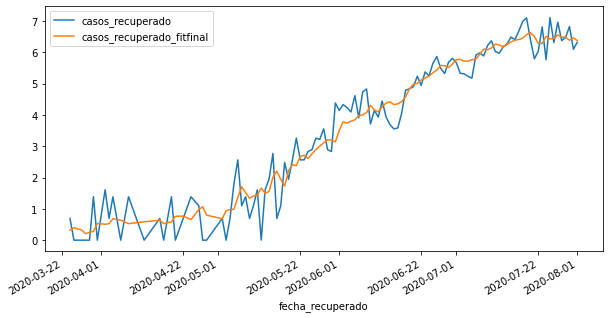

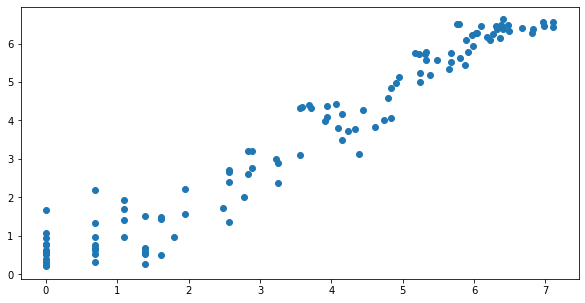

In [ ]:
M1RecuperadoLogTrain['casos_recuperado_fitfinal']=M1RecuperadoLogTrain['casos_recuperado_fit']+M1RecuperadoLogTrain['Errores_fit']
plot=M1RecuperadoLogTrain[['casos_recuperado', 'casos_recuperado_fitfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTrain['casos_recuperado'],M1RecuperadoLogTrain['casos_recuperado_fitfinal'])
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


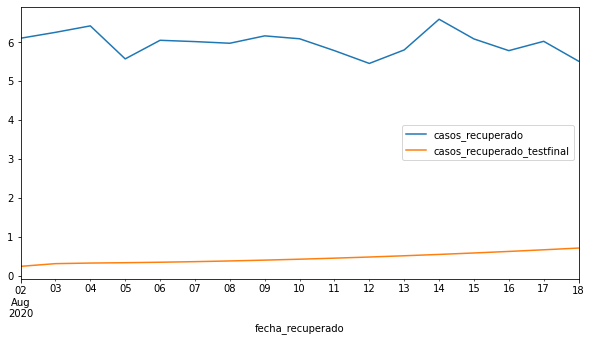

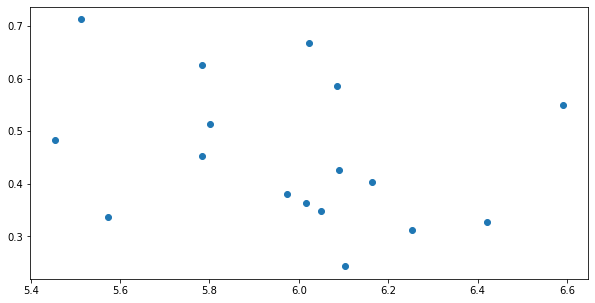

In [ ]:
M1RecuperadoLogTest['Errores_test']=arima.predict(n_periods=(len(M1RecuperadoLogTest)))
M1RecuperadoLogTest['casos_recuperado_testfinal']=M1RecuperadoLogTest['casos_recuperado_test']+M1RecuperadoLogTest['Errores_test']

plot=M1RecuperadoLogTest[['casos_recuperado', 'casos_recuperado_testfinal']].plot(figsize=(10, 5))
plt.figure(figsize=(10,5))
plt.scatter(M1RecuperadoLogTest['casos_recuperado'],M1RecuperadoLogTest['casos_recuperado_testfinal'])
plt.show() 

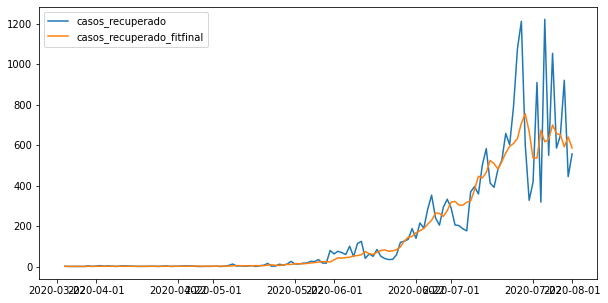

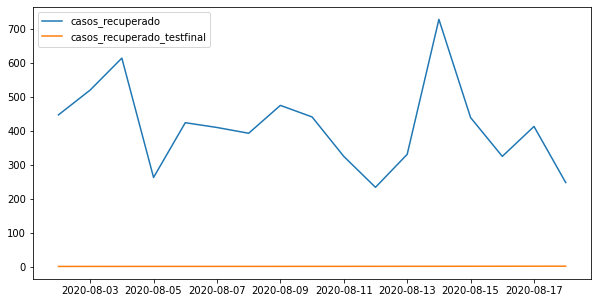

In [ ]:
FM1Recuperado=np.exp(M1RecuperadoLogTrain)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_fitfinal'])
plt.legend(['casos_recuperado','casos_recuperado_fitfinal'])
plt.show()

FM1Recuperado=np.exp(M1RecuperadoLogTest)
plt.plot(FM1Recuperado['casos_recuperado'])
plt.plot(FM1Recuperado['casos_recuperado_testfinal'])
plt.legend(['casos_recuperado','casos_recuperado_testfinal'])
plt.show()

#x_fore=M1NuevosLogForecast.index.factorize()[0].reshape(-1,1)
#x_forepoly=poly.transform(x_fore)
#np.exp(model.predict(x_forepoly))

# Metodología 2: Nuevos RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


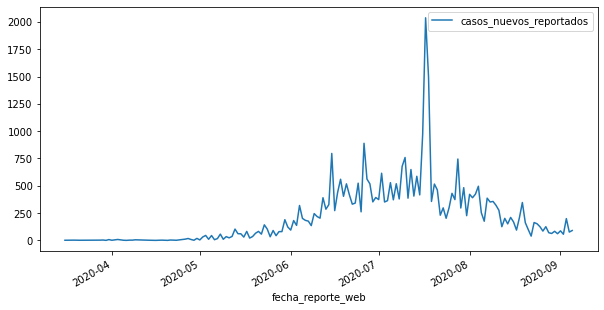

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)
M2Nuevos.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2NuevosTrain=M2Nuevos[:int(len(M2Nuevos)*p_train)]
M2NuevosTest=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]
M2NuevosForecast=M2Nuevos[int(len(M2Nuevos)*(p_train+p_test)):]
print(M2Nuevos.shape)
print(M2NuevosTrain.shape)
print(M2NuevosTest.shape)
print(M2NuevosForecast.shape)

(165, 1)
(132, 1)
(19, 1)
(14, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2NuevosTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2NuevosTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(125, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0297
Epoch 2/150
4/4 [==============================] - 0s 20ms/step - loss: 0.0197
Epoch 3/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0175
Epoch 4/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0170
Epoch 5/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0132
Epoch 6/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0172
Epoch 7/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0139
Epoch 8/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0146
Epoch 9/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0133
Epoch 10/150
4/4 [==============================] - 0s 23ms/step - loss: 0.0134
Epoch 11/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0128
Epoch 12/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0127
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModBarranquillaNuevos.h5')  # creates a HDF5 file

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 100)            40800     
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
lstm_2 (LSTM)                (None, 7, 100)            80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 282,101
Trainable params: 282,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Getting the predicted 

dataset_train=M2Nuevos[:int(len(M2Nuevos)*p_train)]
dataset_test=M2Nuevos[int(len(M2Nuevos)*p_train):int(len(M2Nuevos)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2NuevosTrain['casos_nuevos_reportados_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2NuevosTest['casos_nuevos_reportados_test']=predicted

(19, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


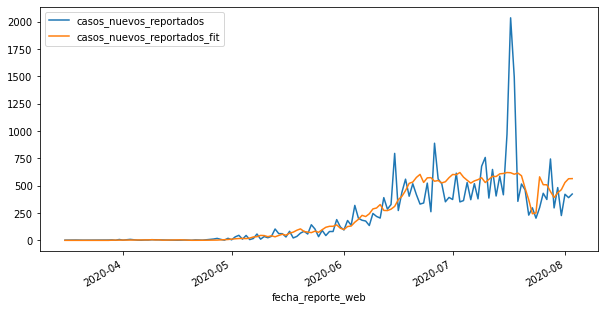

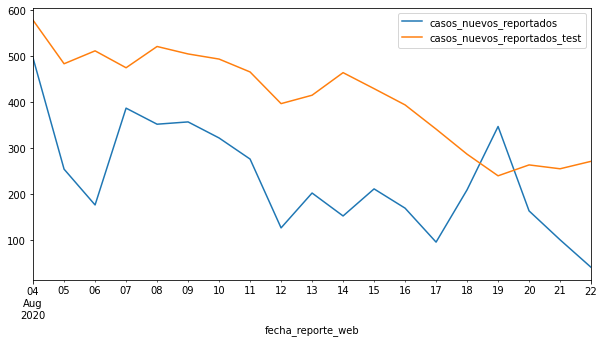

In [ ]:
plot=M2NuevosTrain[['casos_nuevos_reportados', 'casos_nuevos_reportados_fit']].plot(figsize=(10, 5))
plot=M2NuevosTest[['casos_nuevos_reportados', 'casos_nuevos_reportados_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2NuevosTrain['casos_nuevos_reportados'],M2NuevosTrain['casos_nuevos_reportados_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2NuevosTest['casos_nuevos_reportados'],M2NuevosTest['casos_nuevos_reportados_test'])
print('MSE in test: %f' % msetest)


MSE in train: 34501.092162
MSE in test: 40894.236993


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


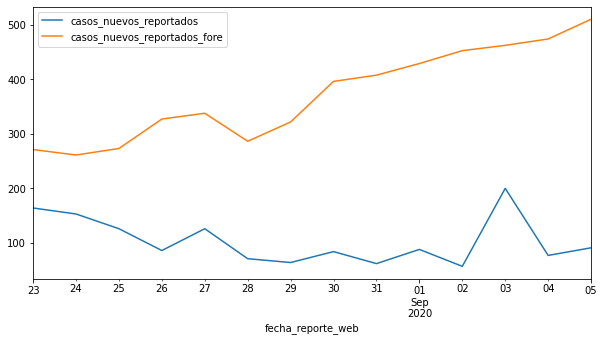

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2NuevosForecast['casos_nuevos_reportados_fore']=fore

plot=M2NuevosForecast[['casos_nuevos_reportados', 'casos_nuevos_reportados_fore']].plot(figsize=(10, 5))

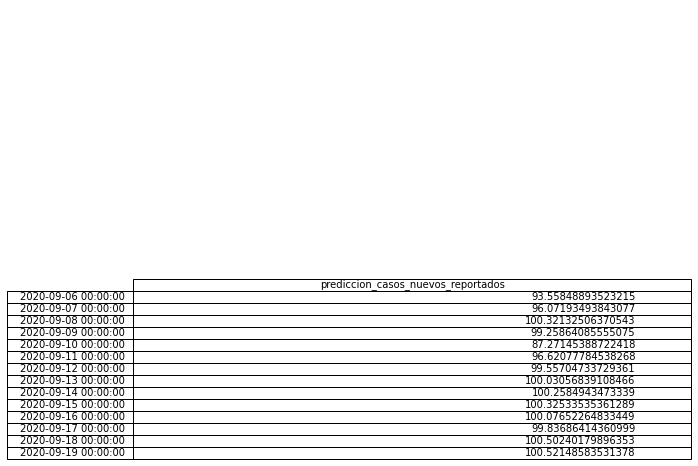

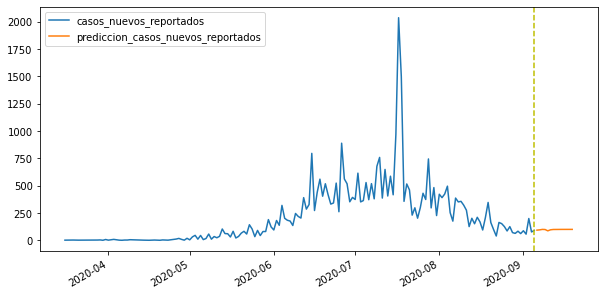

In [ ]:
# tabla con ciudades filtradas para modelar casos nuevos
tabla_nuevos=pd.pivot_table(Datos1,index=['fecha_reporte_web'],values=['id_caso'],aggfunc='count')
tabla_nuevos=pd.DataFrame(tabla_nuevos.to_records())
tabla_nuevos.rename(columns={'id_caso':'casos_nuevos_reportados'},inplace=True)
tabla_nuevos.loc[:,'casos_confirmados']=tabla_nuevos['casos_nuevos_reportados'].cumsum()

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Nuevos=tabla_nuevos.set_index('fecha_reporte_web')
M2Nuevos=M2Nuevos.drop(['casos_confirmados'],axis=1)
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Nuevos[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

from keras.models import load_model
model = load_model('ModBarranquillaNuevos.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

BarranquillaNuevos=sc.inverse_transform(b)

import datetime
index=[M2Nuevos.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
BarranquillaNuevos=pd.DataFrame(data=BarranquillaNuevos, index=index, columns=['prediccion_casos_nuevos_reportados'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, BarranquillaNuevos) 
plt.savefig('./images/27.png')

M2Nuevos.plot().figure.savefig('./images/25.png')#

BarranquillaNuevos.plot().figure.savefig('./images/26.png')

total=pd.concat((M2Nuevos,BarranquillaNuevos),axis = 0)
total.plot()
plt.axvline(x=M2Nuevos.index[-1],color='y',linestyle='--')
plt.savefig('./images/28.png')

BarranquillaNuevos.to_excel('BarranquillaNuevos.xlsx')

# Metodología 2: Muerte RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos fallecidos
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muerte'},inplace=True)

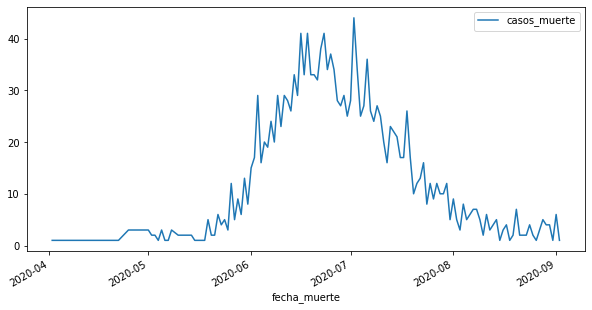

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)
M2Muerte.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2MuerteTrain=M2Muerte[:int(len(M2Muerte)*p_train)]
M2MuerteTest=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]
M2MuerteForecast=M2Muerte[int(len(M2Muerte)*(p_train+p_test)):]
print(M2Muerte.shape)
print(M2MuerteTrain.shape)
print(M2MuerteTest.shape)
print(M2MuerteForecast.shape)

(129, 1)
(103, 1)
(15, 1)
(11, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2MuerteTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2MuerteTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(96, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
3/3 [==============================] - 0s 17ms/step - loss: 0.1928
Epoch 2/150
3/3 [==============================] - 0s 17ms/step - loss: 0.1107
Epoch 3/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0467
Epoch 4/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0544
Epoch 5/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0330
Epoch 6/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0379
Epoch 7/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0268
Epoch 8/150
3/3 [==============================] - 0s 18ms/step - loss: 0.0246
Epoch 9/150
3/3 [==============================] - 0s 17ms/step - loss: 0.0207
Epoch 10/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0215
Epoch 11/150
3/3 [==============================] - 0s 17ms/step - loss: 0.0198
Epoch 12/150
3/3 [==============================] - 0s 16ms/step - loss: 0.0198
Epoch 13/150
3/3 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModBarranquillaMuerte.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Muerte[:int(len(M2Muerte)*p_train)]
dataset_test=M2Muerte[int(len(M2Muerte)*p_train):int(len(M2Muerte)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2MuerteTrain['casos_muerte_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2MuerteTest['casos_muerte_test']=predicted

(15, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


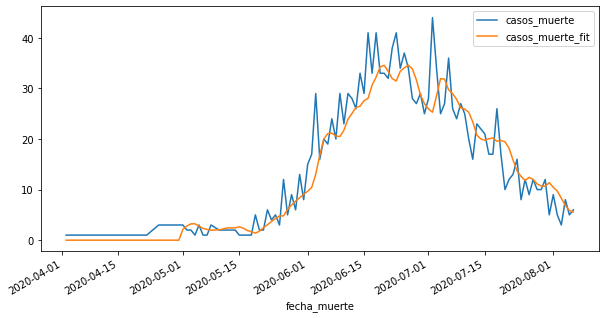

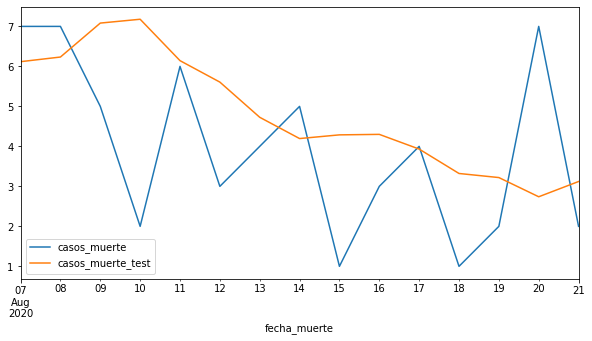

In [ ]:
plot=M2MuerteTrain[['casos_muerte', 'casos_muerte_fit']].plot(figsize=(10, 5))
plot=M2MuerteTest[['casos_muerte', 'casos_muerte_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2MuerteTrain['casos_muerte'],M2MuerteTrain['casos_muerte_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2MuerteTest['casos_muerte'],M2MuerteTest['casos_muerte_test'])
print('MSE in test: %f' % msetest)

MSE in train: 19.894704
MSE in test: 5.287315


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


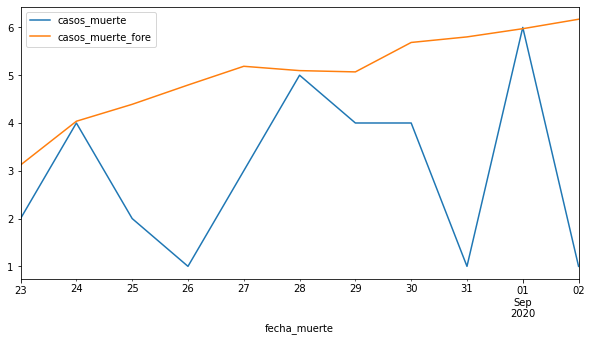

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,12):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2MuerteForecast['casos_muerte_fore']=fore

plot=M2MuerteForecast[['casos_muerte', 'casos_muerte_fore']].plot(figsize=(10, 5))

Terminé fallecidos


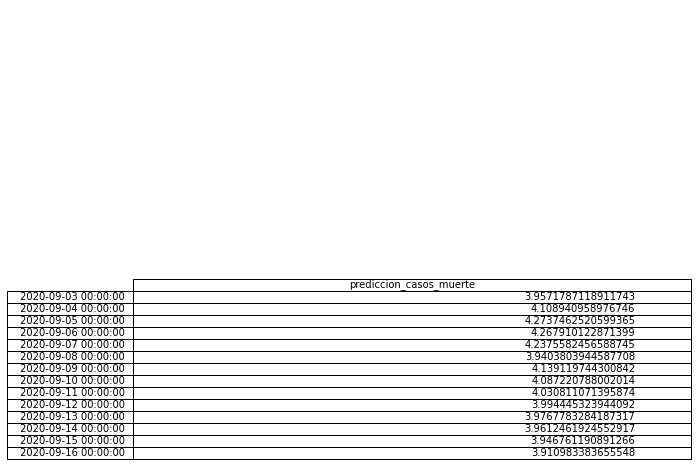

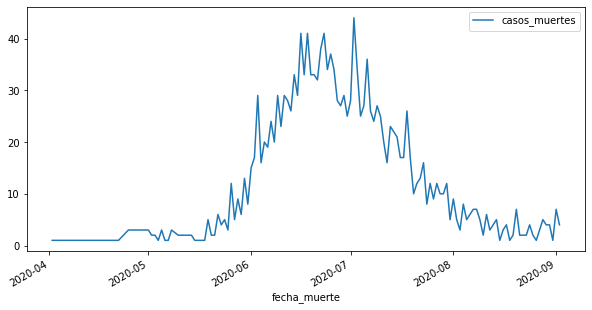

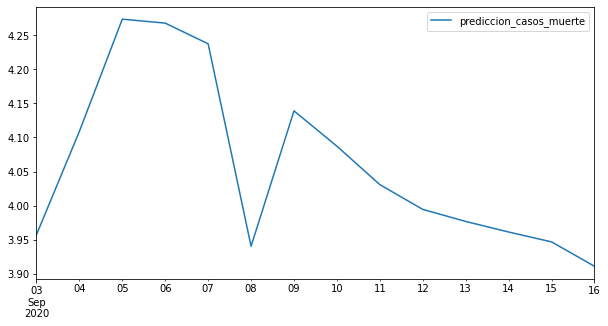

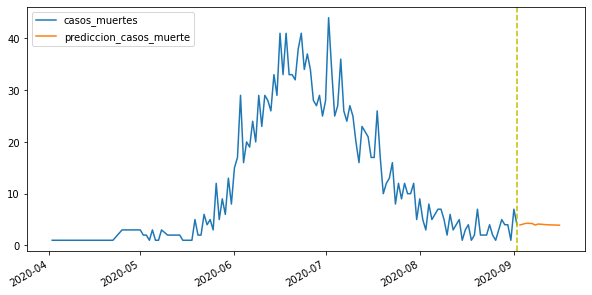

In [ ]:
# tabla con ciudades filtradas para modelar casos muerte
tabla_muerte=pd.pivot_table(Datos1,index=['fecha_muerte'],values=['id_caso'],aggfunc='count')
tabla_muerte=pd.DataFrame(tabla_muerte.to_records())
tabla_muerte.rename(columns={'id_caso':'casos_muertes'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Muerte=tabla_muerte.set_index('fecha_muerte')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Muerte[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModBarranquillaMuerte.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

BarranquillaMuerte=sc.inverse_transform(b)

import datetime
index=[M2Muerte.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
BarranquillaMuerte=pd.DataFrame(data=BarranquillaMuerte, index=index, columns=['prediccion_casos_muerte'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, BarranquillaMuerte) 
plt.savefig('images/31.png')

M2Muerte.plot().figure.savefig('images/29.png')

BarranquillaMuerte.plot().figure.savefig('images/30.png')

total=pd.concat((M2Muerte,BarranquillaMuerte),axis = 0)
total.plot()
plt.axvline(x=M2Muerte.index[-1],color='y',linestyle='--')
plt.savefig('images/32.png')

BarranquillaMuerte.to_excel('BarranquillaMuerte.xlsx')

print("Terminé fallecidos")


# Metodología 2: Recuperados RED NEURONAL

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperados
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

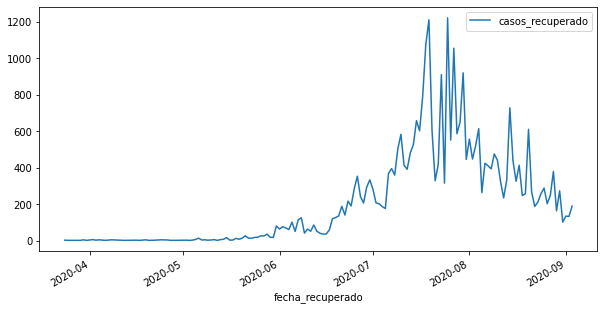

In [ ]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)
M2Recuperado.plot()

In [ ]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

p_train=0.80
p_test=0.12
p_forecast=0.08
M2RecuperadoTrain=M2Recuperado[:int(len(M2Recuperado)*p_train)]
M2RecuperadoTest=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]
M2RecuperadoForecast=M2Recuperado[int(len(M2Recuperado)*(p_train+p_test)):]
print(M2Recuperado.shape)
print(M2RecuperadoTrain.shape)
print(M2RecuperadoTest.shape)
print(M2RecuperadoForecast.shape)

(147, 1)
(117, 1)
(18, 1)
(12, 1)


In [ ]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(M2RecuperadoTrain)

# Creating a data structure with 5 time-steps and 1 output
X_train = []
y_train = []
for i in range(7, len(M2RecuperadoTrain)):
    X_train.append(training_set_scaled[i-7:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(110, 7, 1)

In [ ]:
model = Sequential()
#Adding the first LSTM layer 
model.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train.shape[1], 1)))

# Adding a second LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a third LSTM layer
model.add(LSTM(units = 100, return_sequences = True))


# Adding a fourth LSTM layer
model.add(LSTM(units = 100))

# Adding the output layer
model.add(Dense(units = 1))

# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# simple early stopping
es=EarlyStopping(monitor='loss', mode='auto',verbose=0)

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 150, batch_size = 32)   # 32, 64, 128

Epoch 1/150
4/4 [==============================] - 0s 22ms/step - loss: 0.0761
Epoch 2/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0421
Epoch 3/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0379
Epoch 4/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0226
Epoch 5/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0201
Epoch 6/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0195
Epoch 7/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0169
Epoch 8/150
4/4 [==============================] - 0s 21ms/step - loss: 0.0209
Epoch 9/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0200
Epoch 10/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0177
Epoch 11/150
4/4 [==============================] - 0s 19ms/step - loss: 0.0162
Epoch 12/150
4/4 [==============================] - 0s 18ms/step - loss: 0.0164
Epoch 13/150
4/4 [==============================]

In [ ]:
from keras.models import load_model

model.save('ModBarranquillaRecuperado.h5')  # creates a HDF5 file

In [ ]:
# Getting the predicted 

dataset_train=M2Recuperado[:int(len(M2Recuperado)*p_train)]
dataset_test=M2Recuperado[int(len(M2Recuperado)*p_train):int(len(M2Recuperado)*(p_train+p_test))]

dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 7:].values
inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs)

X_test = []
for i in range(7, len(inputs)):
    X_test.append(inputs[i-7:i, 0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
print(X_test.shape)

fit = model.predict(X_train)
fit = sc.inverse_transform(fit)
fit=np.insert(fit,0,0)
fit=np.insert(fit,1,0)
fit=np.insert(fit,2,0)
fit=np.insert(fit,3,0)
fit=np.insert(fit,4,0)
fit=np.insert(fit,5,0)
fit=np.insert(fit,6,0)


M2RecuperadoTrain['casos_recuperado_fit']=fit

predicted = model.predict(X_test)
predicted = sc.inverse_transform(predicted)
M2RecuperadoTest['casos_recuperado_test']=predicted

(18, 7, 1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


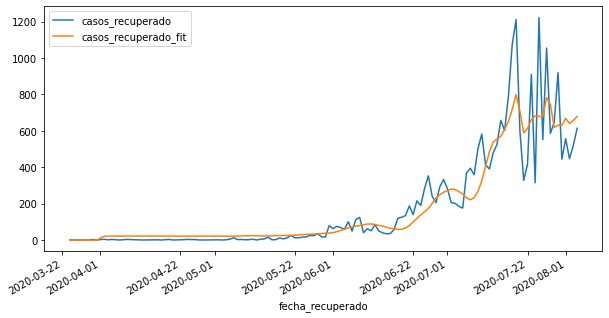

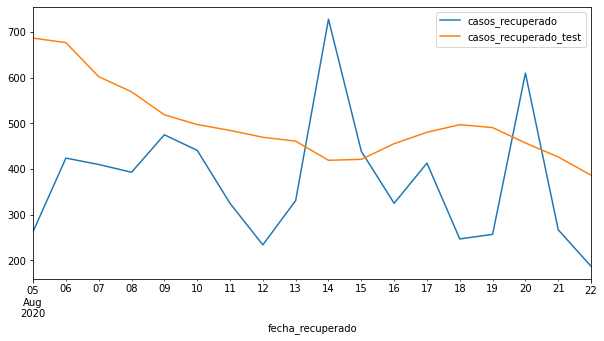

In [ ]:
plot=M2RecuperadoTrain[['casos_recuperado', 'casos_recuperado_fit']].plot(figsize=(10, 5))
plot=M2RecuperadoTest[['casos_recuperado', 'casos_recuperado_test']].plot(figsize=(10, 5))

In [ ]:
from sklearn.metrics import mean_squared_error
msetrain = mean_squared_error(M2RecuperadoTrain['casos_recuperado'],M2RecuperadoTrain['casos_recuperado_fit'])
print('MSE in train: %f' % msetrain)

msetest = mean_squared_error(M2RecuperadoTest['casos_recuperado'],M2RecuperadoTest['casos_recuperado_test'])
print('MSE in test: %f' % msetest)

MSE in train: 13582.955384
MSE in test: 40979.161557


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


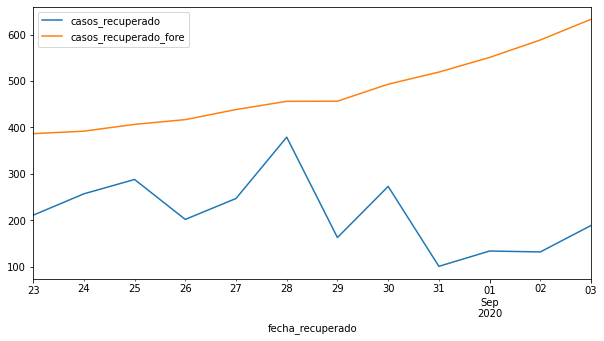

In [ ]:
a=([[[float(X_test[-1][i])] for i in range(0,len(X_test[-1]))]])

b=[]
for i in range(1,13):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

fore= sc.inverse_transform(b)
M2RecuperadoForecast['casos_recuperado_fore']=fore

plot=M2RecuperadoForecast[['casos_recuperado', 'casos_recuperado_fore']].plot(figsize=(10, 5))

Terminé recuperados


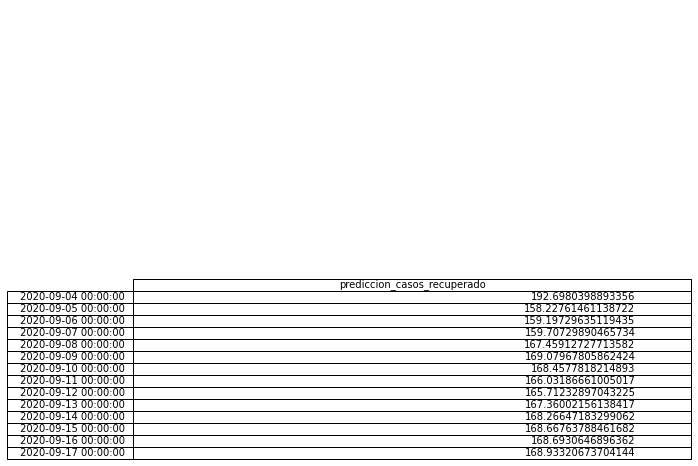

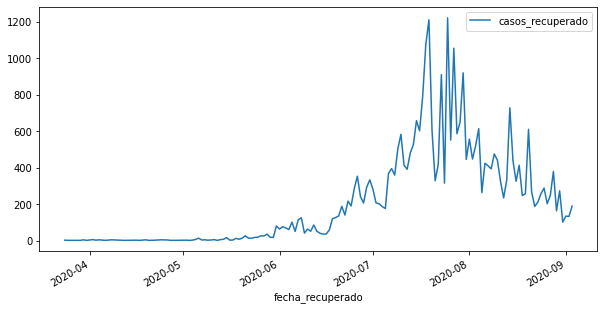

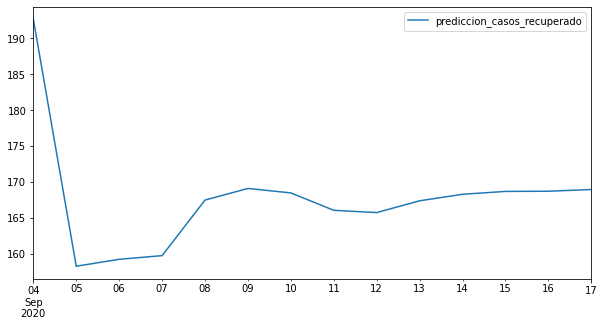

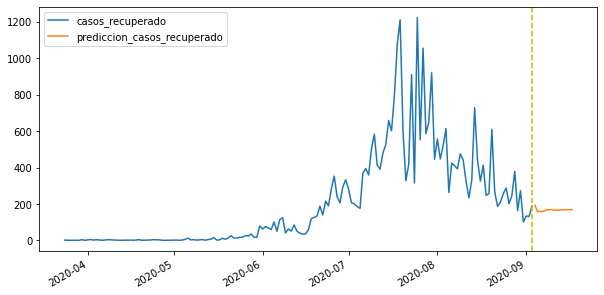

In [ ]:
# tabla con ciudades filtradas para modelar casos recuperado
tabla_recuperado=pd.pivot_table(Datos1,index=['fecha_recuperado'],values=['id_caso'],aggfunc='count')
tabla_recuperado=pd.DataFrame(tabla_recuperado.to_records())
tabla_recuperado.rename(columns={'id_caso':'casos_recuperado'},inplace=True)

from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Serie normal
M2Recuperado=tabla_recuperado.set_index('fecha_recuperado')
plt.rcParams["figure.figsize"] = (10,5)

temp=M2Recuperado[-7:].values.reshape(-1,1)
sc=MinMaxScaler(feature_range=(0, 1))
temp=sc.fit_transform(temp)

model = load_model('ModBarranquillaRecuperado.h5')

a=([[[float(temp[i])] for i in range(0,len(temp))]])

b=[]
for i in range(1,15):
  pred = model.predict(a)
  b.append([float(pred)])
  a[0].pop(0)
  a[0].append([float(pred)])

BarranquillaRecuperado=sc.inverse_transform(b)

import datetime
index=[M2Recuperado.index[-1]+datetime.timedelta(days=i) for i in range(1,15)]
BarranquillaRecuperado=pd.DataFrame(data=BarranquillaRecuperado, index=index, columns=['prediccion_casos_recuperado'])

from pandas.plotting import table 
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)  
ax.yaxis.set_visible(False)  
table(ax, BarranquillaRecuperado) 
plt.savefig('images/35.png')

M2Recuperado.plot().figure.savefig('images/33.png')

BarranquillaRecuperado.plot().figure.savefig('images/34.png')

total=pd.concat((M2Recuperado,BarranquillaRecuperado),axis = 0)
total.plot()
plt.axvline(x=M2Recuperado.index[-1],color='y',linestyle='--')
plt.savefig('images/36.png')

print("Terminé recuperados")